In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from fractions import Fraction
import math

In [2]:
#Col =1 if collusion case, 0 if Nash case. All other parameters follow our notation.
# Generalize to any T and #players n_ply
def calc_C(n_colply):
  C = np.eye(n_ply)
  for i in range(n_colply):
    for j in range(i+1, n_colply):
        C[i,j] = 1
        C[j,i] = 1
  return C

def theta_inv(b,mu,Col,n_ply, n_colply):
  C = calc_C(n_colply)
  if Col==1:
    the = b*(np.ones((n_ply,n_ply))+C) + np.diag(mu)
  else:
    the = b*(np.ones((n_ply,n_ply))+np.eye(n_ply)) + np.diag(mu)
  inv = np.linalg.inv(the)
  return inv

def gamma_inv(B,mu,Col,n_ply, n_colply):
  g = sum([theta_inv(B[t],mu,Col,n_ply, n_colply) for t in range(T)])
  ginv = np.linalg.inv(g)
  return ginv

def Psi(B,mu,Col,n_ply, n_colply):
  ginv = gamma_inv(B,mu,Col,n_ply, n_colply)
  tinv_b = []
  for t in range(T):
    tinv_b.append(theta_inv(B[t],mu,Col,n_ply, n_colply))

  #calculate psi1
  mat1 = []
  for i in range(T):
    for j in range(T):
      if i==j: # ii element of Psi1. Each element is n_ply X n_ply matrix.
        mat1.append((tinv_b[i]) - (tinv_b[i] @ ginv @ tinv_b[i]))
      else: # ij element of Psi1
        mat1.append(- (tinv_b[i] @ ginv @ tinv_b[j]))
  #concatentate columns of Psi1 for each row
  mat1row = []
  for i in range(T):
    mat1row.append(np.concatenate(mat1[i*T : (i+1)*T],axis=1))
  #concatenate rows of Psi1
  psi1_mat = np.concatenate(mat1row,axis=0)

  #calculate psi2
  mat2 =[]
  for i in range(T):
    mat2.append((tinv_b[i] @ ginv)) #element i of Psi2
  #concatenate elements into a column vector
  psi2_mat = np.concatenate(mat2,axis=0)
  return (psi1_mat, psi2_mat)

def x_eq(x_b,A,B,mu,D,Col,n_ply, n_colply):
  vec2 = np.concatenate([A[t]*np.ones(n_ply) for t in range(T)],axis=0)
  vec1 = np.multiply(np.concatenate([mu for t in range(T)],axis=0),x_b)
  Psi1, Psi2 = Psi(B,mu,Col,n_ply, n_colply)
  x = Psi1 @ (vec1-vec2) + Psi2 @ D
  return x

def cost(x,x_b,A,B,mu,n_ply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c = 0
  for i in range(n_ply):
    c = c + sum([p[t]*x[n_ply*t + i] + 0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return c

def cost_comp(x,x_b,A,B,mu,n_ply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c1 = 0
  c2 = 0
  for i in range(n_ply):
    c1 = c1 + sum([p[t]*x[n_ply*t + i] for t in range(T)])
    c2 = c2 + sum([0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return (c1, c2)

def cost_ply(ply,x,x_b,A,B,mu,n_ply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c = sum([p[t]*x[n_ply*t + ply] + 0.5*mu[ply]*(x[n_ply*t+ply]-x_b[n_ply*t+ply])**2 for t in range(T)])
  return c

def cost_colply(x,x_b,A,B,mu,n_ply, n_colply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c = 0
  for i in range(n_colply):
    c = c + sum([p[t]*x[n_ply*t + i] + 0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return c

def cost_colply_comp(x,x_b,A,B,mu,n_ply,n_colply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c1 = 0
  c2 = 0
  for i in range(n_colply):
    c1 = c1 + sum([p[t]*x[n_ply*t + i] for t in range(T)])
    c2 = c2 + sum([0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return (c1, c2)

def cost_nonply(x,x_b,A,B,mu,n_ply, n_colply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c = 0
  for i in range(n_colply, n_ply):
    c = c + sum([p[t]*x[n_ply*t + i] + 0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return c

def cost_nonply_comp(x,x_b,A,B,mu,n_ply,n_colply):
  p = [A[t] + (B[t] * np.sum(x[(n_ply*t):(n_ply*(t+1))])) for t in range(T)]
  c1 = 0
  c2 = 0
  for i in range(n_colply, n_ply):
    c1 = c1 + sum([p[t]*x[n_ply*t + i] for t in range(T)])
    c2 = c2 + sum([0.5*mu[i]*(x[n_ply*t+i]-x_b[n_ply*t+i])**2 for t in range(T)])
  return (c1, c2)

def thm_checks(B,mu,D):
  #assume B same across time
  checks = np.zeros(1+n_ply)
  del_c = theta_inv(B[0],mu,1) @ np.multiply(mu, D)
  del_n = theta_inv(B[0],mu,0) @ np.multiply(mu, D)
  c_term = (np.sum(del_c))**2 + sum([(mu[i]/(2*B[0]))*(del_c[i]-D[i])**2 for i in range(n_ply)])
  n_term = (np.sum(del_n))**2 + sum([(mu[i]/(2*B[0]))*(del_n[i]-D[i])**2 for i in range(n_ply)])
  if c_term > n_term:
    #Nash better.
    checks[0] = 1
  for pk in range(n_ply):
    c_term = (np.sum(del_c)* del_c[pk]) + ((mu[pk]*(del_c[pk]-D[pk])**2)/(2*B[0]))
    n_term = (np.sum(del_n)* del_n[pk]) + ((mu[pk]*(del_n[pk]-D[pk])**2)/(2*B[0]))
    if c_term > n_term:
      #Nash better.
      checks[pk+1] = 1
  return checks

In [3]:
def Avg_randwelfare(n_ply, n_colply, mu_lev, b, dem_lev, A, eta1, eta2):
  n_runs = 100
  B = np.array([b for t in range(T)])
  c_CE_traj = []
  c_NE_traj = []
  ccol_CE_traj = []
  ccol_NE_traj = []
  cnon_CE_traj = []
  cnon_NE_traj = []
  c_ratio_traj = []
  ccol_ratio_traj = []
  cnon_ratio_traj = []
  c_CE_t1_traj = []
  c_CE_t2_traj = []
  c_NE_t1_traj = []
  c_NE_t2_traj = []
  ccol_CE_t1_traj = []
  ccol_CE_t2_traj = []
  ccol_NE_t1_traj = []
  ccol_NE_t2_traj = []
  cnon_CE_t1_traj = []
  cnon_CE_t2_traj = []
  cnon_NE_t1_traj = []
  cnon_NE_t2_traj = []

  for run in range(n_runs):
    mu = []
    D = []
    for i in range(n_ply):
        if i <= n_colply:
            mu.append(mu_lev[np.random.binomial(size=1, n=1, p= 0)[0]])
            D.append(dem_lev[np.random.binomial(size=1, n=1, p= 0)[0]])
        else: 
            mu.append(mu_lev[np.random.binomial(size=1, n=1, p= 1)[0]])
            D.append(dem_lev[np.random.binomial(size=1, n=1, p= 1)[0]])
    mu = np.array(mu)
    D = np.array(D)
    alpha = np.concatenate([np.array([eta1 for i in range(int(T/2))]), np.array([eta2 for i in range(int(T - int(T/2)))])],axis=0)
    alpha = alpha.flatten('C')
    alpha = alpha/ np.sum(alpha)
    x_b = np.array([alpha[t]*D for t in range(T)])
    x_b = x_b.flatten('C')
    #print('x_B',x_b,"D",D)
    #equilibrium and cost calculations
    x_NE = x_eq(x_b,A,B,mu,D,0,n_ply, n_colply)
    x_CE = x_eq(x_b,A,B,mu,D,1,n_ply, n_colply)
    c_CE_run = cost(x_CE,x_b,A,B,mu,n_ply)
    c_NE_run = cost(x_NE,x_b,A,B,mu,n_ply)
    (c_CE_t1_run, c_CE_t2_run) = cost_comp(x_CE,x_b,A,B,mu,n_ply)
    (c_NE_t1_run, c_NE_t2_run) = cost_comp(x_NE,x_b,A,B,mu,n_ply)
    (ccol_CE_t1_run, ccol_CE_t2_run) = cost_colply_comp(x_CE,x_b,A,B,mu,n_ply,n_colply)
    (ccol_NE_t1_run, ccol_NE_t2_run) = cost_colply_comp(x_NE,x_b,A,B,mu,n_ply,n_colply)
    (cnon_CE_t1_run, cnon_CE_t2_run) = cost_nonply_comp(x_CE,x_b,A,B,mu,n_ply,n_colply)
    (cnon_NE_t1_run, cnon_NE_t2_run) = cost_nonply_comp(x_NE,x_b,A,B,mu,n_ply,n_colply)
    ccol_CE_run =cost_colply(x_CE,x_b,A,B,mu,n_ply, n_colply)
    ccol_NE_run =cost_colply(x_NE,x_b,A,B,mu,n_ply, n_colply)
    cnon_CE_run =cost_nonply(x_CE,x_b,A,B,mu,n_ply, n_colply)
    cnon_NE_run =cost_nonply(x_NE,x_b,A,B,mu,n_ply, n_colply)
    c_CE_traj.append(c_CE_run)
    c_NE_traj.append(c_NE_run)
    ccol_CE_traj.append(ccol_CE_run)
    ccol_NE_traj.append(ccol_NE_run)
    cnon_CE_traj.append(cnon_CE_run)
    cnon_NE_traj.append(cnon_NE_run)
    c_ratio_traj.append(c_NE_run/c_CE_run)
    ccol_ratio_traj.append(ccol_NE_run/ccol_CE_run)
    cnon_ratio_traj.append(cnon_NE_run/cnon_CE_run)
    c_CE_t1_traj.append(c_CE_t1_run)
    c_CE_t2_traj.append(c_CE_t2_run)
    c_NE_t1_traj.append(c_NE_t1_run)
    c_NE_t2_traj.append(c_NE_t2_run)
    ccol_CE_t1_traj.append(ccol_CE_t1_run)
    ccol_CE_t2_traj.append(ccol_CE_t2_run)
    ccol_NE_t1_traj.append(ccol_NE_t1_run)
    ccol_NE_t2_traj.append(ccol_NE_t2_run)
    cnon_CE_t1_traj.append(cnon_CE_t1_run)
    cnon_CE_t2_traj.append(cnon_CE_t2_run)
    cnon_NE_t1_traj.append(cnon_NE_t1_run)
    cnon_NE_t2_traj.append(cnon_NE_t2_run)
  rt_N =math.sqrt(n_runs)
  return (np.mean(c_CE_traj), np.mean(c_NE_traj), np.mean(ccol_CE_traj), np.mean(ccol_NE_traj), np.mean(cnon_CE_traj), np.mean(cnon_NE_traj),
          np.mean(c_CE_t1_traj), np.mean(c_CE_t2_traj), np.mean(c_NE_t1_traj), np.mean(c_NE_t2_traj), np.mean(ccol_CE_t1_traj), np.mean(ccol_CE_t2_traj), np.mean(ccol_NE_t1_traj), np.mean(ccol_NE_t2_traj), np.mean(cnon_CE_t1_traj), np.mean(cnon_CE_t2_traj), np.mean(cnon_NE_t1_traj), np.mean(cnon_NE_t2_traj),
          np.std(c_CE_traj)/rt_N, np.std(c_NE_traj)/rt_N, np.std(ccol_CE_traj)/rt_N, np.std(ccol_NE_traj)/rt_N, np.std(cnon_CE_traj)/rt_N, np.std(cnon_NE_traj)/rt_N, np.std(c_ratio_traj)/rt_N, np.std(ccol_ratio_traj)/rt_N, np.std(cnon_ratio_traj)/rt_N,
          np.std(c_CE_t1_traj)/rt_N, np.std(c_CE_t2_traj)/rt_N, np.std(c_NE_t1_traj)/rt_N, np.std(c_NE_t2_traj)/rt_N, np.std(ccol_CE_t1_traj)/rt_N, np.std(ccol_CE_t2_traj)/rt_N, np.std(ccol_NE_t1_traj)/rt_N, np.std(ccol_NE_t2_traj)/rt_N, np.std(cnon_CE_t1_traj)/rt_N, np.std(cnon_CE_t2_traj)/rt_N, np.std(cnon_NE_t1_traj)/rt_N, np.std(cnon_NE_t2_traj)/rt_N
          )

#Plot functions
colors = ['blue','red','green','brown','pink','purple','gray','olive','cyan','orange']

def plot_data(data, var, labels, plotname, yname):
  n_graphs = len(data)
  var_len = len(var)
  if var_len !=0:
    for gr in range(n_graphs):
      plt.errorbar(np.arange(1,n_ply,1), data[gr] ,yerr = var[gr] ,color = colors[gr], label= labels[gr])
  else:
    for gr in range(n_graphs):
      plt.plot(data[gr],color = colors[gr], label= labels[gr])
  plt.title(plotname)
  plt.ylabel(yname)
  plt.xticks(np.arange(1,n_ply,1),np.arange(1,n_ply,1))### Change ticks
  plt.xlabel("Number of players in collusion")
  plt.legend()
  plt.show()

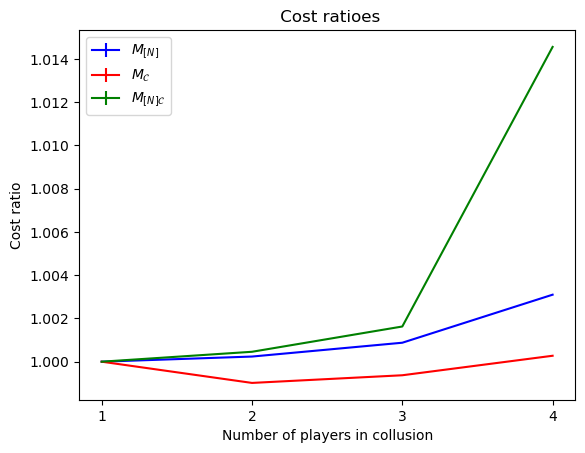

In [4]:
#parameters
T = 10
n_ply = 5
mu_lev = [0.1, 1]
b = 0.50
dem_lev = [1, 5]


a_non_unif = 0.4
A = 0.5+a_non_unif*np.random.rand(T)
eta1 = 0.5
eta2 = 0.5

#data arrays
c_CE = []
c_NE = []
ccol_CE = []
ccol_NE = []
cnon_CE = []
cnon_NE = []
c_ratio = [] #NE/CE
ccol_ratio = [] #NE/CE
cnon_ratio = [] #NE/CE
varc_CE = []
varc_NE = []
varccol_CE = []
varccol_NE = []
varcnon_CE = []
varcnon_NE = []
varc_ratio = [] #NE/CE
varccol_ratio = [] #NE/CE
varcnon_ratio = [] #NE/CE
#Create array template. In {}, fill c / ccol / cnon for average total cost / average cost of collusion / average cost of non-collusion
c_CEt1_data = []
c_CEt2_data = []
c_NEt1_data = []
c_NEt2_data = []

#simulate for different number of players in collusion
for n_colply in range(1,n_ply):
  #calculate averages
  (c_CEt, c_NEt, ccol_CEt, ccol_NEt, cnon_CEt, cnon_NEt,
   c_CEt1, c_CEt2, c_NEt1, c_NEt2, ccol_CEt1, ccol_CEt2, ccol_NEt1, ccol_NEt2, cnon_CEt1, cnon_CEt2, cnon_NEt1, cnon_NEt2, #returns mean of price dependent terms in cost
   varc_CEt, varc_NEt, varccol_CEt, varccol_NEt, varcnon_CEt, varcnon_NEt, varc_ratiot, varccol_ratiot, varcnon_ratiot,
   varc_CEt1, varc_CEt2, varc_NEt1, varc_NEt2, varccol_CEt1, varccol_CEt2, varccol_NEt1, varccol_NEt2, varcnon_CEt1, varcnon_CEt2, varcnon_NEt1, varcnon_NEt2 #returns variance of price dependent terms in cost
   ) = Avg_randwelfare(n_ply, n_colply, mu_lev, b, dem_lev, A, eta1, eta2)
  c_CE.append(c_CEt)
  c_NE.append(c_NEt)
  ccol_CE.append(ccol_CEt)
  ccol_NE.append(ccol_NEt)
  cnon_CE.append(cnon_CEt)
  cnon_NE.append(cnon_NEt)
  c_ratio.append(c_NEt/c_CEt)
  ccol_ratio.append(ccol_NEt/ ccol_CEt)
  cnon_ratio.append(cnon_NEt/ cnon_CEt)
  varc_CE.append(varc_CEt)
  varc_NE.append(varc_NEt)
  varccol_CE.append(varccol_CEt)
  varccol_NE.append(varccol_NEt)
  varcnon_CE.append(varcnon_CEt)
  varcnon_NE.append(varcnon_NEt)
  varc_ratio.append(varc_ratiot)
  varccol_ratio.append(varccol_ratiot)
  varcnon_ratio.append(varcnon_ratiot)
  #Append array template. In {}, fill c / ccol / cnon for average total cost / average cost of collusion / average cost of non-collusion
  c_CEt1_data.append(c_CEt1)
  c_CEt2_data.append(c_CEt2)
  c_NEt1_data.append(c_NEt1)
  c_NEt2_data.append(c_NEt2)


#generate plots. If you don't want error bars, put in var =[].
# plot_data(data=(c_CEt1_data, c_CEt2_data), var=[], labels=['CE_t1','CE_t2'], plotname="COst terms", yname="Cost")
plot_data(data=(c_ratio, ccol_ratio, cnon_ratio), var= [varc_ratio, varccol_ratio, varcnon_ratio], labels= ['$M_{[N]}$', '$M_{\mathcal{C}}$','$M_{[N] \mathcal{C}}$'], plotname = " Cost ratioes", yname= "Cost ratio")
# plot_data(data=(c_NE, c_CE), var = [varc_NE, varc_CE], labels= ['c(NE)','c(CE)'], plotname = "Average cost in equilibrium", yname= "Average cost")
# plot_data(data=(ccol_NE, ccol_CE),var = [varccol_NE, varccol_CE], labels= ['$c_{col}$(NE)','$c_{col}$(CE)'], plotname = "Average cost of collusion players", yname= "Average cost")
# plot_data(data=(cnon_NE, cnon_CE), var = [varcnon_NE, varcnon_CE],labels= ['$c_{non-col}$(NE)','$c_{non-col}$(CE)'], plotname = "Average cost of non-collusion players", yname= "Average cost")